<a href="https://colab.research.google.com/github/archyyu/encoder-related/blob/main/Bidirectional_RNN_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)

In [7]:
# Hyperparameters
hidden_size = 100
embedding_dim = 20
seq_length = 25
learning_rate = 1e-1
batch_size = 20
deep_num = 3
dropout_prob = 0.1

In [43]:
df = pd.read_csv('https://raw.githubusercontent.com/archyyu/publicResource/main/chat_dataset.csv')


pad = '[pad]'
mask = '[MASK]'
data = []
targets = []
for index, row in df.iterrows():
  data.append(row['message'])
  targets.append(row['sentiment'])

datalen = []
for line in data:
  datalen.append(len(line.split(' ')))


targetset = sorted(set(targets))
sentiment_to_index = {s:i for i, s in enumerate(targetset)}
index_to_sentiment = {i:s for i, s in enumerate(targetset)}


dataset = sorted(set((' '.join(data)).split(' ')))
dataset.append(pad)
dataset.append(mask)
vocab_size = len(dataset)
word_to_index = {w:i for i, w in enumerate(dataset)}
index_to_word = {i:w for i, w in enumerate(dataset)}

pad_index = word_to_index[pad]

n = (int)(len(data) * 0.9)
training_data = data[:n]
val_data = data[n:]


lines = []
for item in data:
  lines.append(item.split(' '))

max_line = max([len(line) for line in lines])

for item in lines:
  for _ in range(max_line - len(item)):
    item.append(pad)

X = []
for line in lines:
  item = [word_to_index[word] for word in line]
  X.append(item)

Y = []
for i in range(len(targets)):
  item = sentiment_to_index[targets[i]]
  Y.append(item)

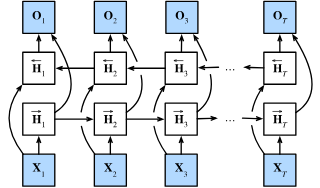

In [37]:
class SimpleRNN(nn.Module):
  def __init__(self, hidden_size):
    super(SimpleRNN, self).__init__()
    self.i2h = nn.Linear(hidden_size, hidden_size, bias=False)
    self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)
    self.ob = nn.Parameter(torch.zeros(1, hidden_size))
    # self.layer_norm = nn.LayerNorm(hidden_size)

  def forward(self, pre_h_list):
    h_list = []
    for i in range(pre_h_list.size(1)):
      if i == 0:
        h = torch.tanh(self.i2h(pre_h_list[:, i, :]) + self.ob)
      else:
        h = torch.tanh(self.i2h(pre_h_list[:, i, :]) + self.h2h(h) + self.ob)
      h_list.append(h)

    return torch.stack(h_list, dim=1)

class DeepRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, deep_num):
    super(DeepRNN, self).__init__()
    self.deep_num = deep_num
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.e2h = nn.Linear(embedding_dim, hidden_size, bias=False)
    self.forwardrnn = SimpleRNN(hidden_size)
    self.backwardrnn = SimpleRNN(hidden_size)
    self.h2o = nn.Linear(hidden_size * 2, vocab_size, bias=False)
    self.ob = nn.Parameter(torch.zeros(1, vocab_size))

  def forward(self, x):
    x = self.embedding(x)
    B,T,C = x.shape
    h = self.e2h(x)

    f_h_list = self.forwardrnn(h)

    b_h_list = self.backwardrnn(torch.flip(h, [1]))

    y = self.h2o(torch.cat((f_h_list, b_h_list), dim=-1)) + self.ob
    return y

# Loss function
criterion = nn.CrossEntropyLoss()

# Model initialization
model = DeepRNN(vocab_size, embedding_dim, hidden_size, deep_num)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

In [11]:
def get_batch():
  inputs = []
  targets = []
  mask_index_list = []
  masks = []
  n = torch.randint(len(X) - batch_size, [1]).item()
  for i in range(batch_size):
    inputs_item = torch.tensor(X[n + i])

    mask_index = torch.randint(datalen[n + 1], [1])

    targets.append(inputs_item[mask_index])
    mask_index_list.append(torch.tensor([i,mask_index]))

    inputs_item[mask_index] = word_to_index[mask]

    inputs.append(inputs_item)

    masks.append(inputs_item != pad_index)

  return torch.stack(inputs), torch.stack(targets), torch.stack(mask_index_list), torch.stack(masks).unsqueeze(1)

In [44]:
n_iters = 10000
for i in range(n_iters):
  inputs, targets, indices, masks = get_batch()

  predicts = model(inputs)

  #print(targets.view(-1).shape)
  outputs = predicts[indices[:,0],indices[:,1]]
  #print(outputs.shape)

  optimizer.zero_grad(set_to_none=True)

  loss = criterion(outputs, targets.view(-1))

  loss.backward()

  optimizer.step()

  if i%1000 == 0:
    print(f'i {i}, loss:{loss.item()}')

i 0, loss:0.9475736618041992
i 1000, loss:1.3827742338180542
i 2000, loss:0.8159180879592896
i 3000, loss:1.9110572338104248
i 4000, loss:1.35969877243042
i 5000, loss:0.5200411677360535
i 6000, loss:0.6221491098403931
i 7000, loss:0.8754768371582031
i 8000, loss:1.0409244298934937
i 9000, loss:0.8141913414001465


In [47]:
n = torch.randint(len(X) - 200,[1]).item()
for line in data[-n:-n + 15]:
  hgg = [word_to_index[word] for word in line.split(' ')]
  linelen = len(hgg)
  for i in range(max_line - len(hgg)):
    hgg.append(word_to_index[pad])
  maskindex = torch.randint(linelen,[1]).item()
  hgg[maskindex] = word_to_index['[MASK]']
  print(' '.join([index_to_word[item] for item in hgg]))
  hgg = torch.tensor(hgg).unsqueeze(0)
  mask = (hgg != pad_index)
  predict = model(hgg)
  values, indexes = torch.topk(predict[0][maskindex],3)
  for item in indexes:
    print('  ',index_to_word[item.item()])

I need to buy new shoes for work. my old ones are [MASK] out 👞🛍️ [pad] [pad] [pad] [pad] [pad] [pad]
   worn
   have
   happy
I just got a $500 ticket for parking in the [MASK] spot 😠🎫 [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]
   wrong
   movie
   for
My phone bill this month is [MASK] more than usual. I don't know why 📱💸 [pad] [pad] [pad] [pad] [pad] [pad]
   $200
   slow
   tolerable
I tried a new restaurant and got food poisoning. [MASK] I'm stuck in bed 😷🤢 [pad] [pad] [pad] [pad] [pad] [pad]
   now
   [pad]
   week
I can't believe my rent just went up $300. how am I supposed to [MASK] that? 🏠💰 [pad] [pad] [pad] [pad]
   afford
   use
   them
I have to work on Saturday this week and I was planning to [MASK] to a concert 😩🎶 [pad] [pad] [pad]
   tackle
   be
   now
[MASK] internet has been down all day and I can't get any work done 🖥️🤬 [pad] [pad] [pad] [pad] [pad] [pad]
   The
   I'm
   I
I lost my credit [MASK] and someone just charged $1000 on it 🤦‍♀️💳 [pad] [pad] [pad] [pad]

this time I use rnn as an encoder to do the BERT job
the result is not bad
the RNN I use is bidirectional
so It could get the leftward and rightward of the mask into account
it is not good as attention, but it is not bad